# Forecast of time series using ARIMA

In this notebook, you'll perform a time series analysis using the Autoregressive Integrated Moving Average (ARIMA) modeling technique in Python. ARIMA modeling, in theory, is the most general class of models for forecasting a time series.

A time series is a collection of data points that are collected at constant time intervals. What differentiates a time series from regular regression problem data is that the observations are time dependent and, along with an increasing or decreasing trend, many time series exhibit seasonal trends. The ARIMA technique seeks to model these trends in data over time and then extrapolate into the future to obtain forecasts. Time series modeling is a powerful method to derive insights from time-based data and make informed decisions about future trends.

In this notebook, you will analyze data from Quandl. The data describes the Bank of England's official statistics on spot exchange rates for the Euro into US dollars (USD). More information on the the data source and Euro exchange rates prior to 1999 can be found here.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import json

from io import StringIO
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## 1. Data

Time series with daily prices of EUR/USD.

In [26]:
data_path = '../data/BOE-XUDLERD.csv'

df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'])
df = df.sort_index()

df.head(5)

,Value
Date,
1975-01-02,0.7633
1975-01-03,0.7585
1975-01-06,0.7524
1975-01-07,0.7510
1975-01-08,0.7554


Plot of the data with daily granularity to check if everything checks.

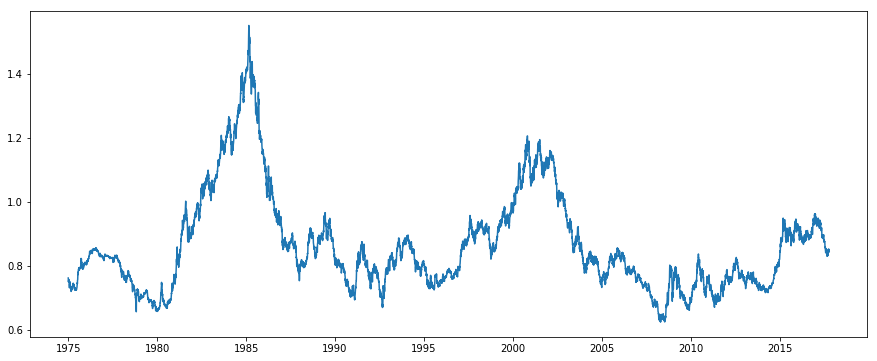

In [27]:
plt.plot(df['Value'])

We are going to resample the time series by downsampling to week granularity.

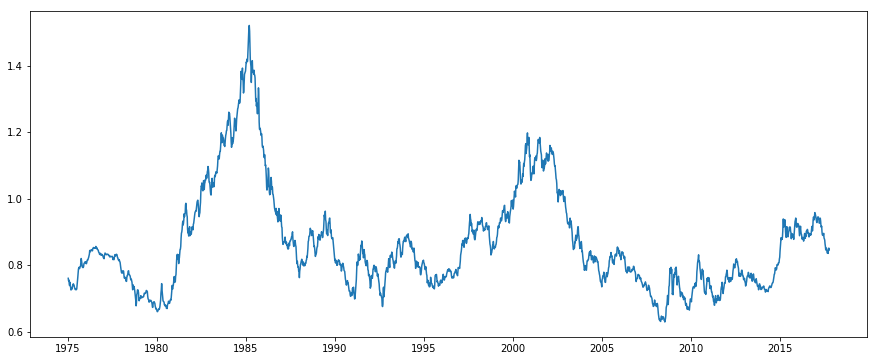

In [30]:
ts_week = df.resample('W').mean()

plt.plot(ts_week)

## 2. Dickey-Fuller Test

What is meant by checking the stationarity of a time series and why do you care about it?
In a stationary time series, the statistical properties over time must be constant and autoconvariance must be time independent. Normally, when running a regular regression, you expect the observations to be independent of each other. In a time series, however, you know that the observations are time dependent. In order to use regression techniques on time dependent variables, the data must be stationary. The techniques that apply to independent random variables also apply to stationary random variables.

There are two ways to check the stationarity of a time series. The first is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences. **The second way is to use the Dickey-Fuller test, a statistical test with the null hypothesis that the time series is non-stationary.** If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.

Calculate the moving variances, plot the results and apply the Dickey-Fuller test on the time series:

In [35]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
 
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print (dfoutput)

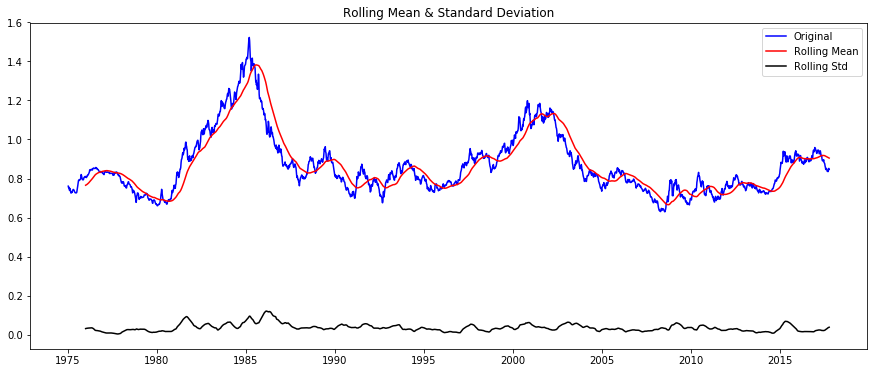

Results of Dickey-Fuller Test:
Test Statistic                   -2.071788
p-value                           0.256009
#Lags Used                        2.000000
Number of Observations Used    2230.000000
Critical Value (1%)              -3.433286
Critical Value (5%)              -2.862837
Critical Value (10%)             -2.567460
dtype: float64


In [40]:
test_stationarity(ts_week['Value'])

Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary.

Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

## 3. Stationarize the time series

If your time series reveals a trend or seasonality, this is an indication that it is non-stationary. You can stationarize the time series by calculating the trend and seasonality and removing these factors from the model. You can apply different transformations to stationarize your data as seen in this list [here](http://people.duke.edu/~rnau/whatuse.htm).

### 3.1 Apply a nonlinear log transformation

Begin by applying a simple, nonlinear log transformation and checking for stationarity:

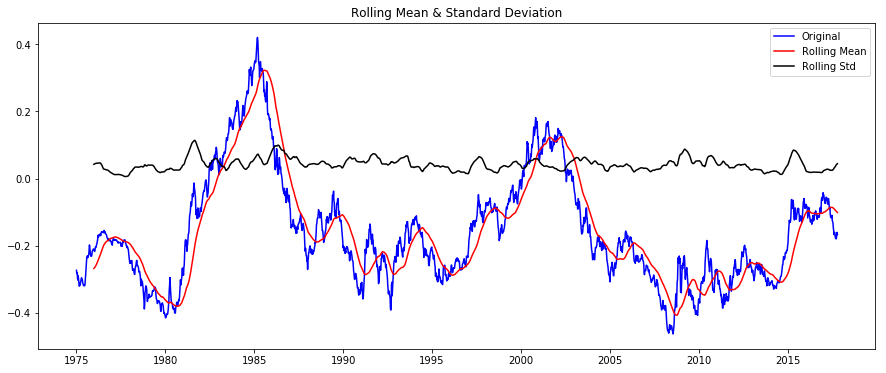

Results of Dickey-Fuller Test:
Test Statistic                   -2.238381
p-value                           0.192611
#Lags Used                        1.000000
Number of Observations Used    2231.000000
Critical Value (1%)              -3.433284
Critical Value (5%)              -2.862836
Critical Value (10%)             -2.567460
dtype: float64


In [42]:
ts_week_log = np.log(ts_week)
test_stationarity(ts_week_log['Value'])

The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05.

### 3.2 Remove trend and seasonality with differencing

Differencing is one of the most common methods of dealing with both trend and seasonality. In first order differencing, you compute the differences between consecutive observations in the time series. This usually improves the stationarity of the time series. In the code, this is confirmed by running the Dickey-Fuller test.

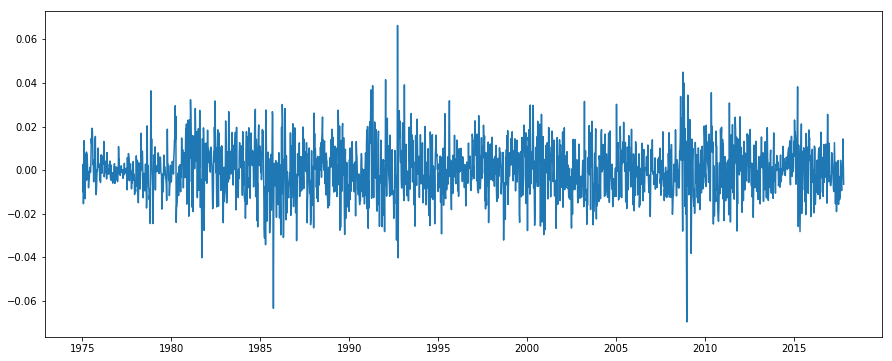

In [49]:
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

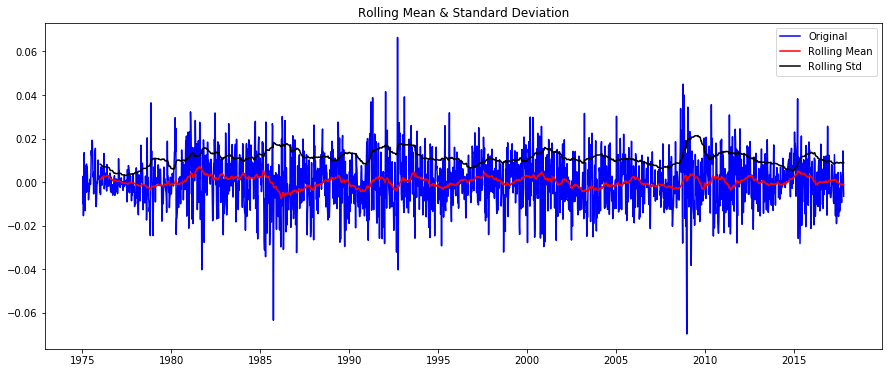

Results of Dickey-Fuller Test:
Test Statistic                  -36.559860
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2231.000000
Critical Value (1%)              -3.433284
Critical Value (5%)              -2.862836
Critical Value (10%)             -2.567460
dtype: float64


In [51]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff['Value'])

The results show that the test statistic is significantly less than the 1% critical value.
This shows you that your time series is now stationary with 99% confidence. Now you can begin to apply statistical models like ARIMA to forecast future Euro exchange rates using this stationarized time series.

## 4. Find Optimal parameter and build an ARIMA model

#### To apply an ARIMA model to your time series, you need to find optimal values for the following three model parameters (p,d,q):

* The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable, the euro rate, in this case. So, if p=2, it means that predictors of x(t) will be x(t-1) and x(t-2).

* The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation. For instance, if q=2, the predictors for x(t) will be e(t-1) and e(t-2) where e(i) is the difference between the moving average at i-th instant and the actual value.

* The number of differences (d): These are the number of non-seasonal differences. In your case, d=1, as you are modeling using the first order differenced time series.

There are two ways to determine the number of AR and MA terms. The first is to use the arma_order_select_ic function in Python. The second uses plots of the autocorrelation function (ACF) and partial autocorrelation function (PACF).
This [article](http://people.duke.edu/~rnau/411arim3.htm) describes in detail the purpose of the ACF and PACF plots.

### 4.1 Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)

Run the next cell to plot the ACF and PACF, and determine the p, d and q model parameters which you will need later as input for the ARIMA model:

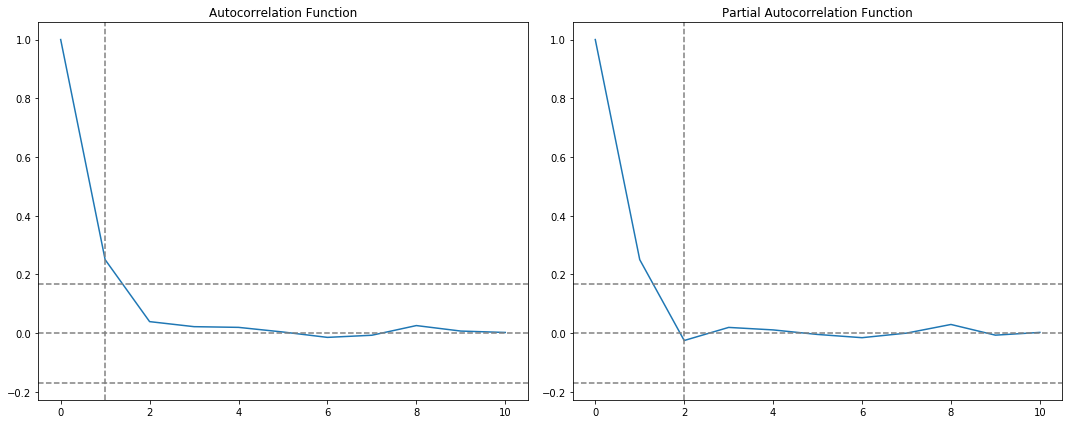

In [61]:
#ACF and PACF plots

lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')

plt.axvline(x=1,linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')

plt.axvline(x=2,linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the 'p' and 'q' values can be determined as follows:
* p: The lag value where the PACF cuts off (drops to 0) for the first time. If you look closely, p=2.
* q: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you look closely, q=1.

This means that the optimal values for the ARIMA(p,d,q) model are (2,1,1).

If your assessment of the ACF and PACF plots differs from the values suggested by the arma_order_select_ic function, you should plug in different values for the p and q terms and use the model fit results to study the [AIC](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/) values and proceed with the model with a lower AIC value.

Text(0.5,1,'RSS: 0.281')

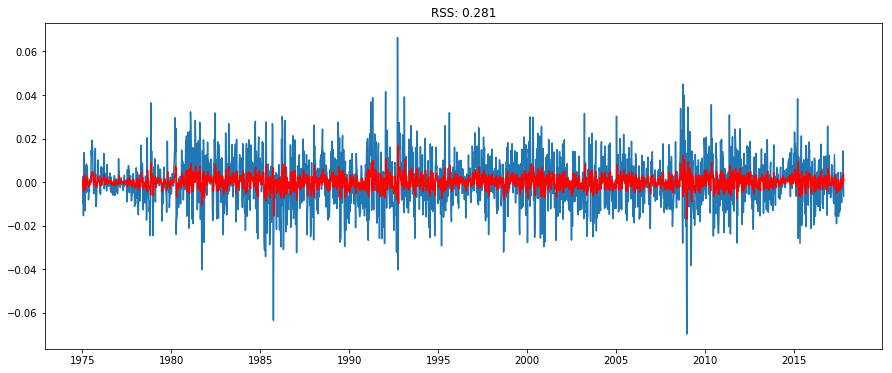

In [70]:
model = ARIMA(ts_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: {:.3f}'.format(sum((results_ARIMA.fittedvalues-ts_week_log_diff['Value'])**2)))

### 4.2 Measure the variance between the data and the values predicted by the model

You can measure whether the results of your model fit the underlying data by using the residual sum of squares (RSS) metric. A small RSS indicates that the model fits tightly to the data.
/
Yet another approach to validate the ARIMA model appropriateness is by performing residual analysis.
Print the results of the ARIMA model and plot the residuals. A density plot of the residual error values indicates a normal distribution centered around zero mean. Also, the residuals do not violate the assumptions of constant location and scale with most values in the range (-1,1).

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2232
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6856.625
Method:                       css-mle   S.D. of innovations              0.011
Date:                Wed, 18 Oct 2017   AIC                         -13703.249
Time:                        20:30:00   BIC                         -13674.696
Sample:                    01-12-1975   HQIC                        -13692.823
                         - 10-15-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           4.53e-05      0.000      0.146      0.884      -0.001       0.001
ar.L1.D.Value    -0.0897      0.488     -0.184      0.854      -1.047       0.868
ar.L2.D.Value     0.0600      0.129     

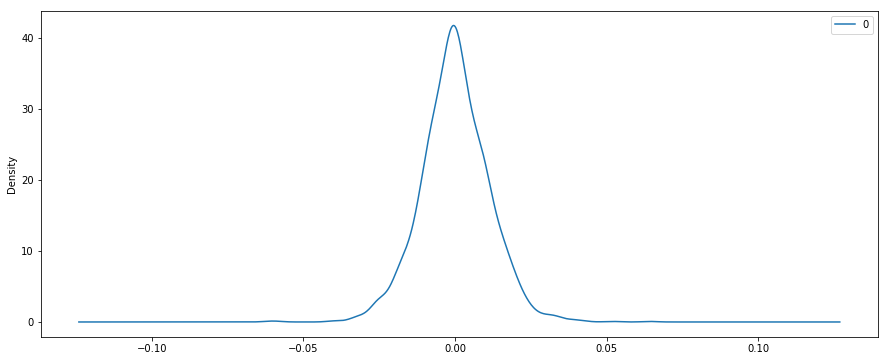

In [72]:
print(results_ARIMA.summary())
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

The model validation checks you ran have confirmed good results.


### 4.3 Scale predictions

Now that the model is returning the results you want to see, you can scale the model predictions back to the original scale. For this, you will remove the first order differencing and take exponent to restore the predictions back to their original scale.

The lower the root mean square error (RMSE) and the closer it is to 0, the better are the model predictions in being closer to actual values.

In [74]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
1975-01-12    0.000045
1975-01-19   -0.002426
1975-01-26    0.000979
1975-02-02   -0.004108
1975-02-09   -0.001142
Freq: W-SUN, dtype: float64


In [84]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0]['Value'], index=ts_week_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

Text(0.5,1,'RMSE: 0.1368')

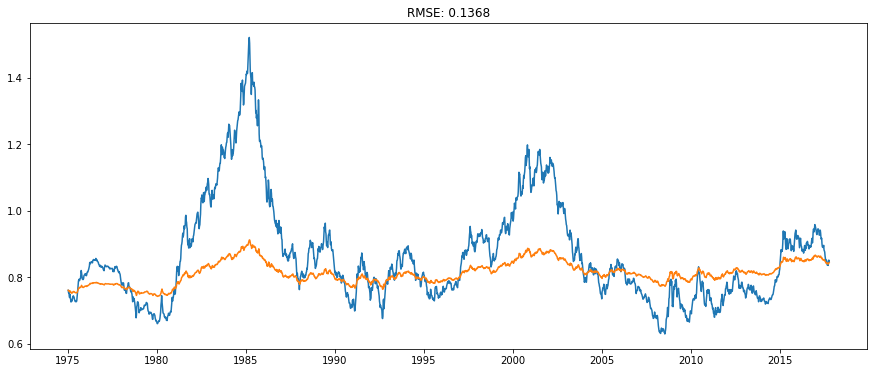

In [85]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week['Value'])**2)/len(ts_week)))

## 6. Perform and visualize time series forecasting

What you have achieved in this notebook so far is in-sample forecasting using ARIMA as you trained the model on the entire time series data. Now you need to split the data set into a training and testing data sets. You will use the training data set to train the ARIMA model and perform out-of-sample forecasting. Then you will compare the results of your out-of-sample predictions for Euro rates with the actual values from the test data set.

You will use the forecast function forecast and perform a rolling one-step forecast with ARIMA. A rolling forecast is required given the dependence on observations during differencing and the AR model. You will re-create the ARIMA model after each new prediction is received. And you will manually keep track of all observations in a list called history, which is seeded with the training data and to which new predictions are appended in each iteration.

In [97]:
train

,Value
Date,
1975-01-05,-0.273253
1975-01-12,-0.283079
1975-01-19,-0.280428
1975-01-26,-0.295876
1975-02-02,-0.302430
1975-02-09,-0.288936
1975-02-16,-0.299188
1975-02-23,-0.307368
1975-03-02,-0.320508


In [104]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size]['Value'], ts_week_log[size:len(ts_week_log)]['Value']
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=0.878545, expected=0.879620


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.